*P-81 Air Quality forecasting(CO2 emissions) *

Business Objective: To forecast Co2 levels for an organization so that the organization can follow government norms with respect to Co2 emission levels.

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab
import matplotlib.pyplot as plt
import scipy.stats as stats
import datetime
import itertools

import sklearn
from sklearn.preprocessing import PowerTransformer
from scipy.stats import boxcox 

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf

import warnings
from math import sqrt
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error


!pip install pmdarima==1.8.0 --upgrade




In [4]:
!pip3 uninstall statsmodels
!pip3 install numpy scipy patsy pandas
!pip3 install statsmodels --upgrade

from statsmodels.tsa.ar_model import AutoReg


Found existing installation: statsmodels 0.13.1
Uninstalling statsmodels-0.13.1:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/statsmodels-0.13.1.dist-info/*
    /usr/local/lib/python3.7/dist-packages/statsmodels/*
Proceed (y/n)? y
  Successfully uninstalled statsmodels-0.13.1
  Using cached statsmodels-0.13.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.8 MB)


In [5]:
import pmdarima as pm
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

from pandas.tseries.offsets import DateOffset
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages

In [ ]:
df = pd.read_csv("/content/CO2 dataset.csv")
df.head()

In [ ]:
df.info()

In [ ]:
dateparse = lambda x: pd.to_datetime(x, format='%Y', errors = 'coerce')
df = pd.read_csv("/content/CO2 dataset.csv", parse_dates=['Year'], index_col='Year', date_parser=dateparse) 
df.head()

In [ ]:
sns.boxplot(df['CO2'])

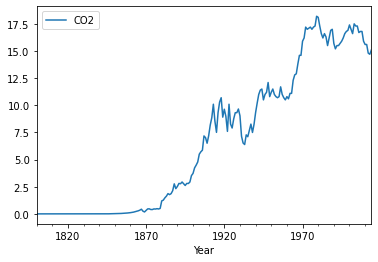

In [129]:
df.plot()

## Transforming data to normal distribution

In [11]:
def diagnostic_plots(df, variable):
    # function to plot a histogram and a Q-Q plot
    # side by side, for a certain variable
    
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[variable].hist()

    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)

    plt.show()
    

### Log Transformation

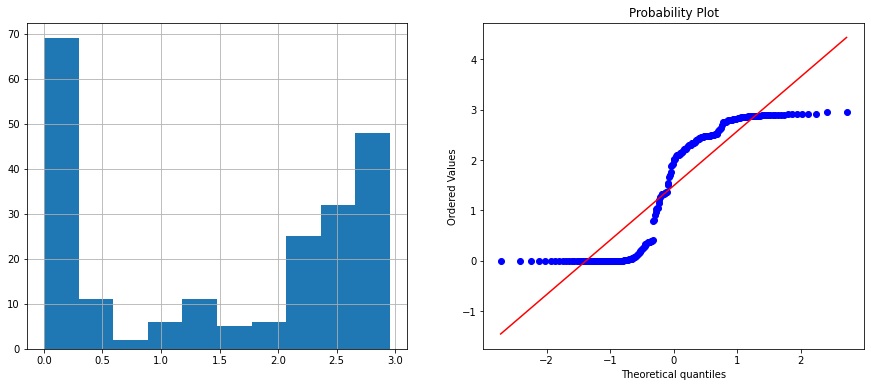

In [12]:
df['Log_co2']=np.log(df['CO2']+1)
diagnostic_plots(df,'Log_co2')

### Reciprocal Transformation

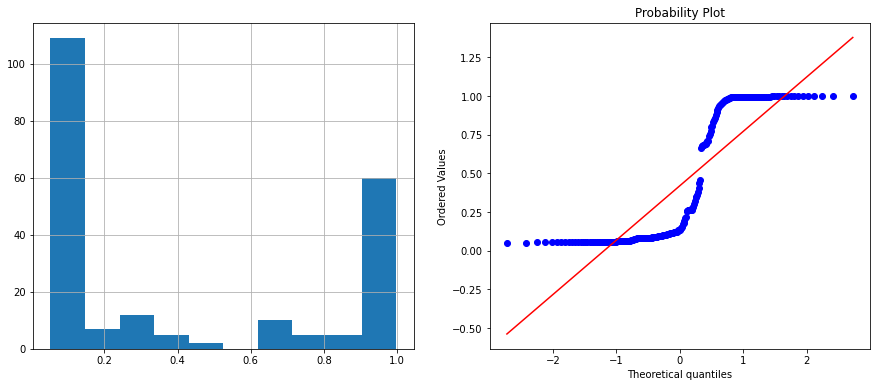

In [13]:
df['Rec_co2']=1/(df['CO2']+1)
diagnostic_plots(df,'Rec_co2')

### Square-Root Transformation

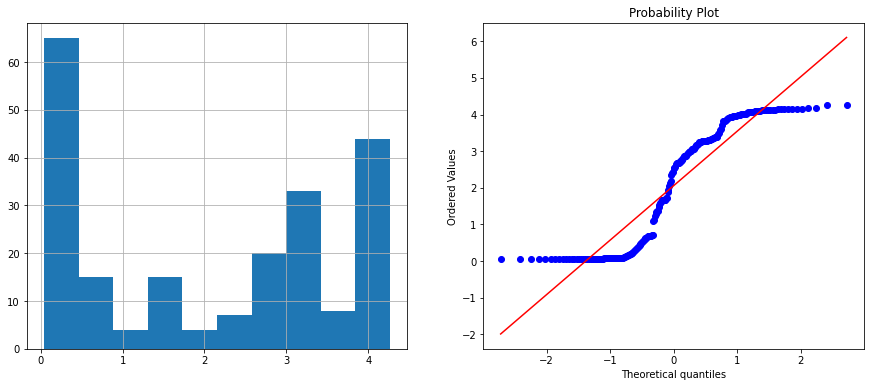

In [14]:
df['sqr_co2']=df['CO2']**(1/2)
diagnostic_plots(df,'sqr_co2')

### Exponential Transformation

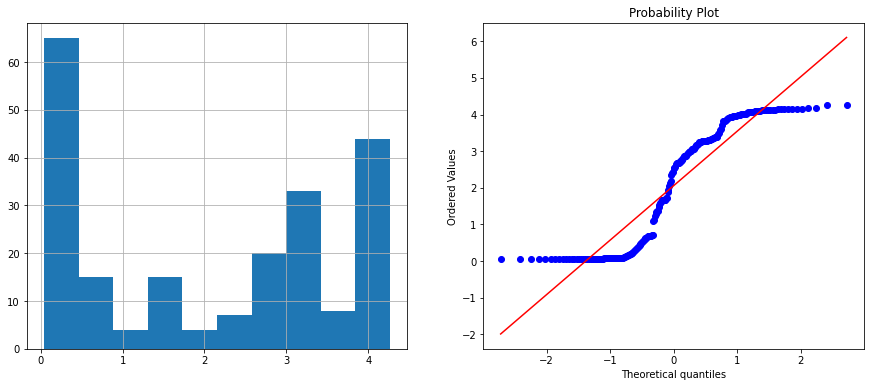

In [15]:
df['Exp_co2']=df['CO2']**(1/5)
diagnostic_plots(df,'sqr_co2')

### Box-cox Transformation

Optimal lambda:  0.1626734565342775


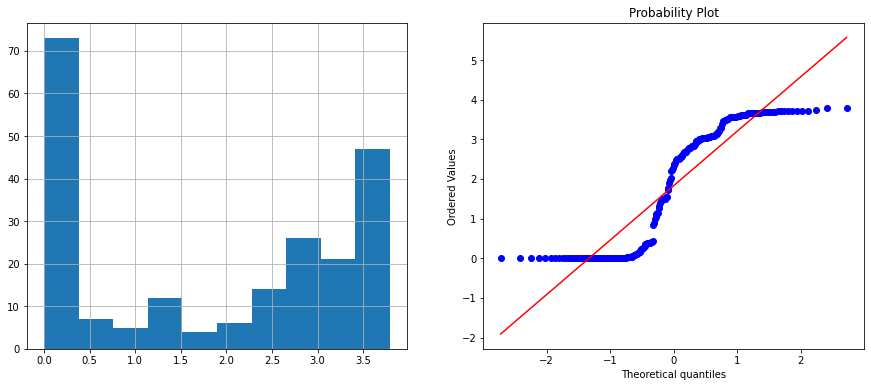

In [16]:
df['co2_boxcox'], param = stats.boxcox(df.CO2+1) # you can vary the exponent as needed

print('Optimal lambda: ', param)

diagnostic_plots(df, 'co2_boxcox')

array([[-1.41804651, -1.48126815,  1.22566669, -1.41804651, -1.41804651,
        -1.4705034 ],
       [-1.41947121, -1.48261311,  1.22571353, -1.41947121, -1.41947121,
        -1.4718637 ],
       [-1.42070347, -1.48377472,  1.22575368, -1.42070347, -1.42070347,
        -1.47303885],
       ...,
       [ 0.99832412,  0.90893134, -1.11259782,  0.99832411,  0.99832411,
         0.92603994],
       [ 0.9939589 ,  0.90676302, -1.10591376,  0.9939589 ,  0.9939589 ,
         0.92349811],
       [ 1.01128301,  0.91533591, -1.13243962,  1.01128301,  1.01128301,
         0.93355673]])

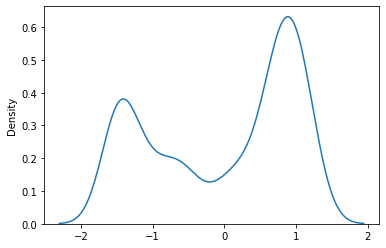

In [17]:

pt = PowerTransformer(method='box-cox')
data = pt.fit_transform(df)
sns.distplot(data, hist=False, kde=True)
data

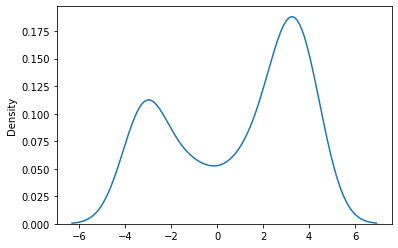

In [18]:
#perform Box-Cox transformation on original data
transformed_data, best_lambda = boxcox(df.CO2) 

#plot the distribution of the transformed data values
sns.distplot(transformed_data, hist=False, kde=True)

In [19]:
df.dtypes

CO2           float64
Log_co2       float64
Rec_co2       float64
sqr_co2       float64
Exp_co2       float64
co2_boxcox    float64
dtype: object

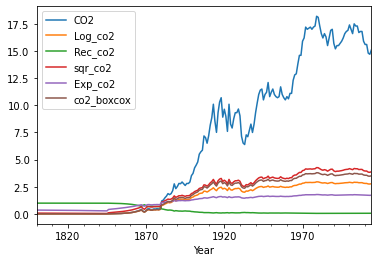

In [20]:
df.plot()

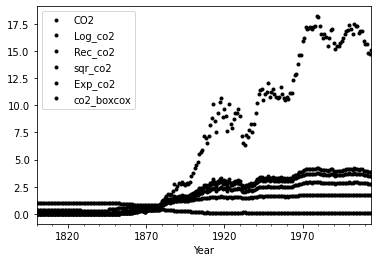

In [21]:
df.plot(style = 'k.')

In [22]:
## DESCRIPTIVE STATISTICS
df.describe()

,CO2,Log_co2,Rec_co2,sqr_co2,Exp_co2,co2_boxcox
count,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000
mean,6.741970,1.490057,0.420248,2.055194,1.159068,1.828802
std,6.522437,1.180641,0.404516,1.590570,0.563587,1.490936
min,0.001750,0.001748,0.052083,0.041833,0.280936,0.001749
25%,0.041050,0.040224,0.080000,0.202429,0.527736,0.040357
50%,6.390000,2.000128,0.135318,2.527845,1.449106,2.363875
75%,11.500000,2.525729,0.960579,3.391165,1.629820,3.123606
max,18.200000,2.954910,0.998253,4.266146,1.786546,3.793997


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f62dee15e10>,
      dtype=object)

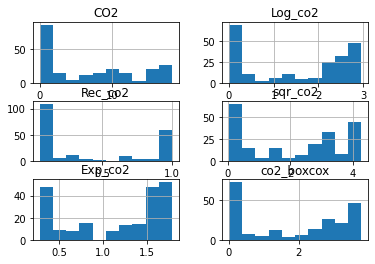

In [23]:
df.hist()

**Since we didnot get any conclusive evidence of being normal distribution. We have decided to move on without transforming it to normal distribution.**

In [24]:
df.head()

,CO2,Log_co2,Rec_co2,sqr_co2,Exp_co2,co2_boxcox
Year,,,,,,
1800-01-01,0.00568,0.005664,0.994352,0.075366,0.355525,0.005667
1801-01-01,0.00561,0.005594,0.994421,0.074900,0.354644,0.005597
1802-01-01,0.00555,0.005535,0.994481,0.074498,0.353882,0.005537
1803-01-01,0.00548,0.005465,0.994550,0.074027,0.352985,0.005467
1804-01-01,0.00542,0.005405,0.994609,0.073621,0.352209,0.005408


**Dropping all transformed values from dataset**

In [25]:
df = df.drop(['co2_boxcox', 'Log_co2','Rec_co2','sqr_co2','Exp_co2'], axis = 1)

In [26]:
df.head()

,CO2
Year,
1800-01-01,0.00568
1801-01-01,0.00561
1802-01-01,0.00555
1803-01-01,0.00548
1804-01-01,0.00542


In [27]:
df.dtypes

CO2    float64
dtype: object

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 215 entries, 1800-01-01 to 2014-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CO2     215 non-null    float64
dtypes: float64(1)
memory usage: 3.4 KB


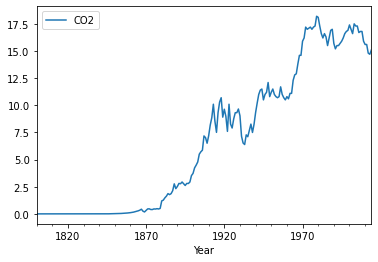

In [29]:
df.plot()

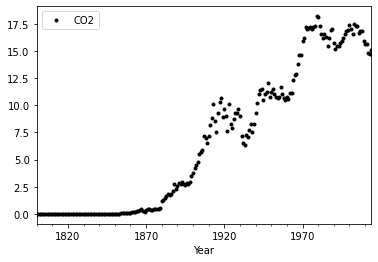

In [30]:
df.plot(style = 'k.')

Preliminary analysis of above plot says that there is presence of clear Level and Trend but we can't say about Seasonality right now.

In [31]:
df.describe()

,CO2
count,215.000000
mean,6.741970
std,6.522437
min,0.001750
25%,0.041050
50%,6.390000
75%,11.500000
max,18.200000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f62de9e3650>]],
      dtype=object)

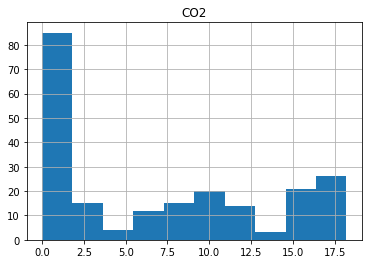

In [32]:
df.hist()

# **A) MODEL BUILDING ON STATIONARY DATA**

# **Test Stationary**

# *** 1.Naive test for stationary by checking constant mean and variance***

In [33]:
X = df.values
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=0.888644, mean2=12.650000
variance1=2.399437, variance2=13.176064


Since mean and variance changes drastically it is evident that out data is not stationary. Let's confirm it using ADFuller test.

# **2.Testing Stationary using ADFuller test**

In [34]:
def TestStationaryPlot(df):
    rol_mean = df.rolling(window = 20, center = False).mean()
    rol_std = df.rolling(window = 20, center = False).std()
    
    plt.plot(df, color = 'blue',label = 'Original Data')
    plt.plot(rol_mean, color = 'red', label = 'Rolling Mean')
    plt.plot(rol_std, color ='black', label = 'Rolling Std')
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)
    
    plt.xlabel('Time in Years', fontsize = 10)
    plt.ylabel('Total Emissions', fontsize = 10)
    plt.legend(loc='best', fontsize = 10)
    plt.title('Rolling Mean & Standard Deviation', fontsize = 10)
    plt.show(block= True)

In [35]:
# null Hypothesis : Data is stationary
#alternate hypothesis : Data is not stationary
def TestStationaryAdfuller(df, cutoff = 0.01):
    df_test = adfuller(df, autolag = 'AIC')
    df_test_output = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in df_test[4].items():
        df_test_output['Critical Value (%s)'%key] = value
    print(df_test_output)
    
    if df_test[1] <= cutoff:
        print("Failed to reject null hypothesis. Data is stationary")
    else:
        print("Failed to accept null hypothesis. Data is non-stationary ")
        

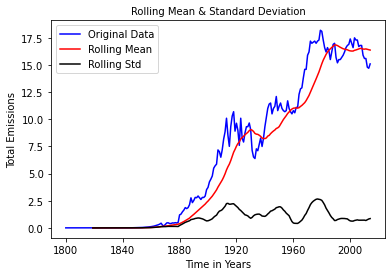

In [36]:
TestStationaryPlot(df)

In [37]:
TestStationaryAdfuller(df)

Test Statistic                  -0.378463
p-value                          0.913633
#Lags Used                       0.000000
Number of Observations Used    214.000000
Critical Value (1%)             -3.461282
Critical Value (5%)             -2.875143
Critical Value (10%)            -2.574020
dtype: float64
Failed to accept null hypothesis. Data is non-stationary 


The emissions mean and the variation in standard deviation (black line) clearly vary with time. This shows that the series has a trend. So, it is not a stationary. Also, the Test Statistic is greater than the critical values with 90%, 95% and 99% confidence levels. Hence, no evidence to accept the null hypothesis. Therefore the series is non stationary. 

# Transforming data to Stationary

Transforming data to stationary using three following methods:
- Moving Average
- Differencing
- Decomposing

# **1. Moving Average**

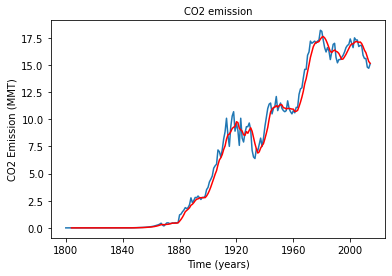

In [38]:
moving_avg = df.rolling(5).mean()
plt.plot(df)
plt.plot(moving_avg, color='red')
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.xlabel('Time (years)', fontsize = 10)
plt.ylabel('CO2 Emission (MMT)', fontsize = 10)
plt.title('CO2 emission', fontsize = 10)
plt.show()

In [39]:
moving_avg_diff = df - moving_avg
moving_avg_diff.head(13)

,CO2
Year,
1800-01-01,NaN
1801-01-01,NaN
1802-01-01,NaN
1803-01-01,NaN
1804-01-01,-0.000128
1805-01-01,-0.000124
1806-01-01,-0.000130
1807-01-01,-0.000126
1808-01-01,-0.000124


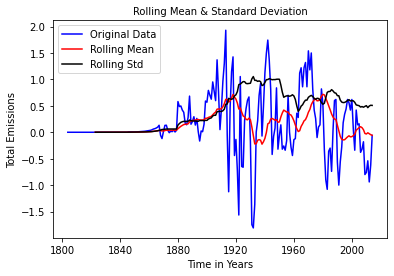

In [40]:
moving_avg_diff.dropna(inplace=True)
TestStationaryPlot(moving_avg_diff)

In [41]:
TestStationaryAdfuller(moving_avg_diff)

Test Statistic                  -3.944115
p-value                          0.001733
#Lags Used                       4.000000
Number of Observations Used    206.000000
Critical Value (1%)             -3.462499
Critical Value (5%)             -2.875675
Critical Value (10%)            -2.574304
dtype: float64
Failed to reject null hypothesis. Data is stationary


The rolling mean values appear to be varying slightly. The Test Statistic is smaller than the 10% 5%, and 1% of critical values. So, we can say with 99% confidence level that the dataset is a stationary series.

## **2. Eliminating trend and seasonality: Differencing**

One of the most common method of dealing with both trend and seasonality is differencing. In this technique, we take the difference of the original observation at a particular instant with that at the previous instant. This mostly works well to improve stationarity. First order differencing can be done as follows:

**2(A) : First order differencing**

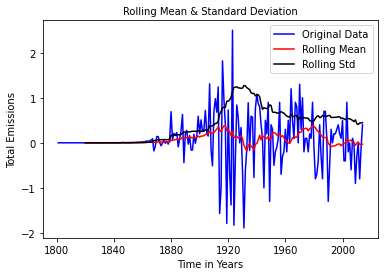

In [42]:
df_first_difference = df - df.shift(1)  
TestStationaryPlot(df_first_difference.dropna(inplace=False))

In [43]:
TestStationaryAdfuller(df_first_difference.dropna(inplace=False))

Test Statistic                  -3.780005
p-value                          0.003119
#Lags Used                      15.000000
Number of Observations Used    198.000000
Critical Value (1%)             -3.463815
Critical Value (5%)             -2.876251
Critical Value (10%)            -2.574611
dtype: float64
Failed to reject null hypothesis. Data is stationary


The first difference improves the stationarity of the series significantly. Let us use also the ***seasonal first order difference*** to remove the seasonality of the data and see how that impacts stationarity of the data.

**2(B) : Seasonal First order differencing**

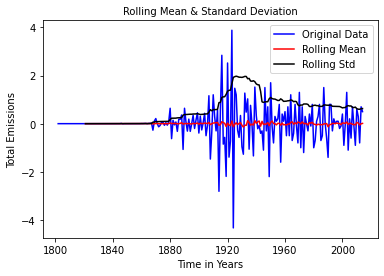

In [44]:
df_seasonal_first_difference = df_first_difference - df_first_difference.shift(1)  
TestStationaryPlot(df_seasonal_first_difference.dropna(inplace=False))

In [45]:
TestStationaryAdfuller(df_seasonal_first_difference.dropna(inplace=False))

Test Statistic                  -5.536081
p-value                          0.000002
#Lags Used                      14.000000
Number of Observations Used    198.000000
Critical Value (1%)             -3.463815
Critical Value (5%)             -2.876251
Critical Value (10%)            -2.574611
dtype: float64
Failed to reject null hypothesis. Data is stationary


We are considering this seasonal first difference for further analysis because it looks more stationary

**3. Eliminating trend and seasonality: Decomposing**

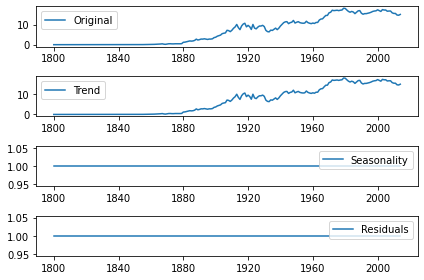

In [46]:
decomposition = seasonal_decompose(df,model="multiplicable")

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(df, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Here we can see that the trend, no seasonaltiy in data and we can model the trend. Here original data and trend both are equal.

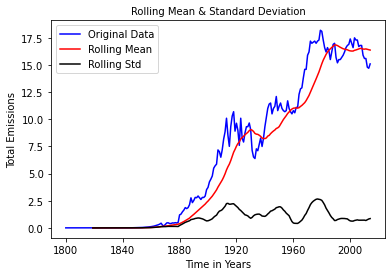

Test Statistic                  -0.378463
p-value                          0.913633
#Lags Used                       0.000000
Number of Observations Used    214.000000
Critical Value (1%)             -3.461282
Critical Value (5%)             -2.875143
Critical Value (10%)            -2.574020
dtype: float64
Failed to accept null hypothesis. Data is non-stationary 


In [47]:
df_decompose = trend
df_decompose.dropna(inplace=True)
TestStationaryPlot(df_decompose)
TestStationaryAdfuller(df_decompose)

# **Plot the ACF and PACF charts and find the optimal parameters**

* **Autocorrelation Function (ACF)**: It is a measure of the correlation between the the time series (ts) with a lagged version of itself.
* **Partial Autocorrelation Function (PACF)**: This measures the correlation between the ts with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons.

In the next step we will be determing the tuning parameters (p and q) of the model by looking at the autocorrelation and partial autocorrelation plots.  The plot below provides a brief guide on how to read the autocorrelation and partial autocorrelation graphs inorder to select the parameters. 

### ACF & PACF plot for seasonal first order difference

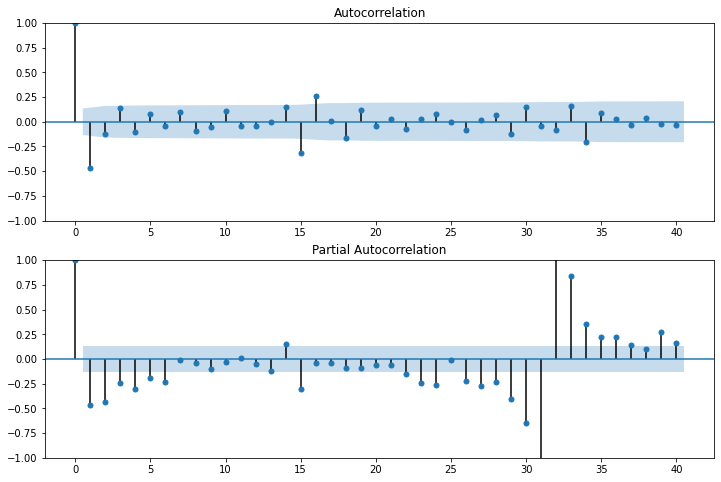

In [48]:
#ACF and PACF plots:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_seasonal_first_difference.dropna(inplace=False), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_seasonal_first_difference.dropna(inplace=False), lags=40, ax=ax2)

We will find optimal parameters (p,d,q) using grid search later

## Data Partitioning

- **Training Data** = Fit the model only to training period
- **Validating Data** = Assess the model performance on validation
- Deploy model by training on whole dataset
- No random partition That’s because the order sequence of the time series should be intact in order to use it for forecasting.

In [ ]:
#using seasonal first order difference
df_seasonal_first_difference.head()

In [50]:
data = df_seasonal_first_difference.dropna(inplace=False)

In [ ]:
data.head()

In [65]:
# Create Training and Test
train = data.iloc[:-10]
test = data.iloc[-10:]

In [53]:
print(train.shape,test.shape)

(203, 1) (10, 1)


In [ ]:
train.head()

In [ ]:
test.head()

**Hyper-parameter Tuning : Finding out optimal (p,d,q)**

In [77]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(train, test, arima_order):
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = stats.ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [78]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(train, test, p_values, d_values, q_values):
    #dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(train, test, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA= %s RMSE= %.3f' % (best_cfg, best_score))

In [79]:
# evaluate parameters
p_values = range(0,5)
d_values = range(0,5)
q_values = range(0,5)
warnings.filterwarnings("ignore")
evaluate_models(train.values, test.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=0.596
ARIMA(0, 0, 1) RMSE=0.531
ARIMA(0, 0, 2) RMSE=0.543
ARIMA(0, 0, 3) RMSE=0.558
ARIMA(0, 0, 4) RMSE=0.540
ARIMA(0, 1, 0) RMSE=1.055
ARIMA(0, 1, 1) RMSE=0.596
ARIMA(0, 1, 2) RMSE=0.500
ARIMA(0, 1, 3) RMSE=0.507
ARIMA(0, 1, 4) RMSE=0.521
ARIMA(0, 2, 0) RMSE=2.139
ARIMA(0, 2, 1) RMSE=1.058
ARIMA(0, 2, 2) RMSE=0.643
ARIMA(0, 2, 3) RMSE=0.490
ARIMA(0, 2, 4) RMSE=0.468
ARIMA(0, 3, 0) RMSE=4.257
ARIMA(0, 3, 1) RMSE=2.145
ARIMA(0, 3, 2) RMSE=1.063
ARIMA(0, 3, 3) RMSE=0.625
ARIMA(0, 3, 4) RMSE=0.524
ARIMA(0, 4, 0) RMSE=8.055
ARIMA(0, 4, 1) RMSE=4.268
ARIMA(0, 4, 2) RMSE=2.156
ARIMA(0, 4, 3) RMSE=1.071
ARIMA(0, 4, 4) RMSE=0.636
ARIMA(1, 0, 0) RMSE=0.556
ARIMA(1, 0, 1) RMSE=0.540
ARIMA(1, 0, 2) RMSE=0.525
ARIMA(1, 0, 3) RMSE=0.534
ARIMA(1, 0, 4) RMSE=0.530
ARIMA(1, 1, 0) RMSE=0.814
ARIMA(1, 1, 1) RMSE=0.556
ARIMA(1, 1, 2) RMSE=0.506
ARIMA(1, 1, 3) RMSE=0.499
ARIMA(1, 1, 4) RMSE=0.507
ARIMA(1, 2, 0) RMSE=1.350
ARIMA(1, 2, 1) RMSE=0.815
ARIMA(1, 2, 2) RMSE=0.580
ARIMA(1, 2, 

## ARIMA model

In [80]:
#3,2,2
import statsmodels.tsa.arima.model as stats
model_arima = stats.ARIMA(train['CO2'],order = (3,2,2))
model_arima = model_arima.fit()
model_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    CO2   No. Observations:                  203
Model:                 ARIMA(3, 2, 2)   Log Likelihood                -199.968
Date:                Mon, 20 Dec 2021   AIC                            411.935
Time:                        19:38:06   BIC                            431.755
Sample:                    01-01-1802   HQIC                           419.955
                         - 01-01-2004                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7613      0.050    -15.161      0.000      -0.860      -0.663
ar.L2         -0.5801      0.074     -7.839      0.000      -0.725      -0.435
ar.L3         -0.2265      0.050     -4.524      0.000      -0.325      -0.128
ma.L1         -1.9896      0.118    -16.805      0.000      -2.222      -1.758
ma.L2          0.9904      0.118      8.369      0.000       0.758       1.222
sigma2         0.3891      0.053      7.327      0.000       0.285       0.493
===================================================================================
Ljung-Box (L1) (Q):                   1.33   Jarque-Bera (JB):               299.99
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):             316.22   Skew:                            -0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [81]:
### make prediction on test set
start = len(train)
end = len(train)+len(test)-1
pred_arima = model_arima.predict(start=start,end=end)
print(pred_arima)

2005-01-01    0.074281
2006-01-01    0.277852
2007-01-01   -0.014880
2008-01-01   -0.176173
2009-01-01    0.070186
2010-01-01    0.042346
2011-01-01   -0.042966
2012-01-01   -0.017795
2013-01-01    0.018697
2014-01-01   -0.004500
Freq: AS-JAN, Name: predicted_mean, dtype: float64


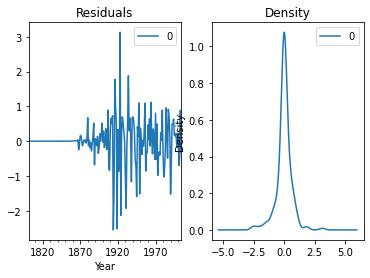

In [85]:
# Plot residual errors
residuals = pd.DataFrame(model_arima.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [93]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse})


In [94]:
stationary_arima_acc = forecast_accuracy(pred_arima.values, test.values)
stationary_arima_acc

{'mae': 0.5385395571282995,
 'mape': 1.021136805287329,
 'me': -0.03729524256668606,
 'mpe': -0.9981169467049351,
 'rmse': 0.6029912127481065}

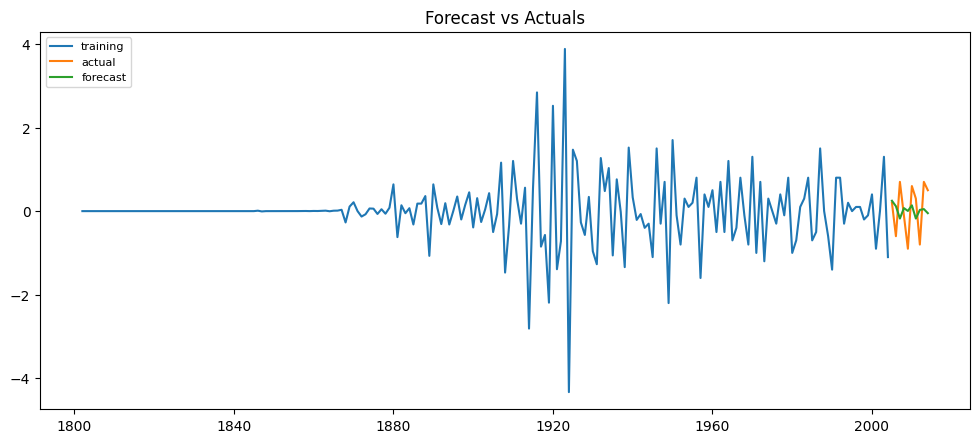

In [95]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_ar, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Auto Regressor (AR) model

In [88]:
model_ar = AutoReg(train,lags = 6).fit()
print(model_ar.summary())

                            AutoReg Model Results                             
Dep. Variable:                    CO2   No. Observations:                  203
Model:                     AutoReg(6)   Log Likelihood                -167.691
Method:               Conditional MLE   S.D. of innovations              0.567
Date:                Mon, 20 Dec 2021   AIC                            351.382
Time:                        19:52:51   BIC                            377.647
Sample:                    01-01-1808   HQIC                           362.014
                         - 01-01-2004                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.040      0.049      0.961      -0.077       0.081
CO2.L1        -0.9605      0.069    -13.851      0.000      -1.096      -0.825
CO2.L2        -0.9901      0.093    -10.671      0.0

In [89]:
pred_ar = model_ar.predict(start=start,end=end,dynamic = False)
print(pred_ar)

2005-01-01    0.247616
2006-01-01    0.117260
2007-01-01   -0.177403
2008-01-01    0.072217
2009-01-01    0.004285
2010-01-01    0.138665
2011-01-01   -0.177407
2012-01-01    0.029230
2013-01-01    0.048723
2014-01-01   -0.048827
Freq: AS-JAN, dtype: float64


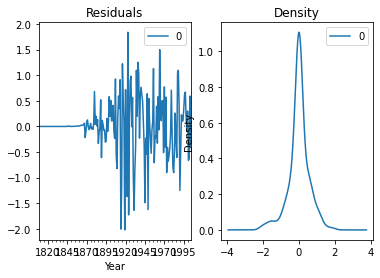

In [90]:
# Plot residual errors
residuals = pd.DataFrame(model_ar.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [91]:
stationary_ar_acc = forecast_accuracy(pred_ar.values, test.values)
stationary_ar_acc

{'mae': 0.5389613483940172,
 'mape': 1.0336141716795533,
 'me': -0.03456407180080832,
 'mpe': -0.9978904329390348,
 'rmse': 0.6064288889374514}

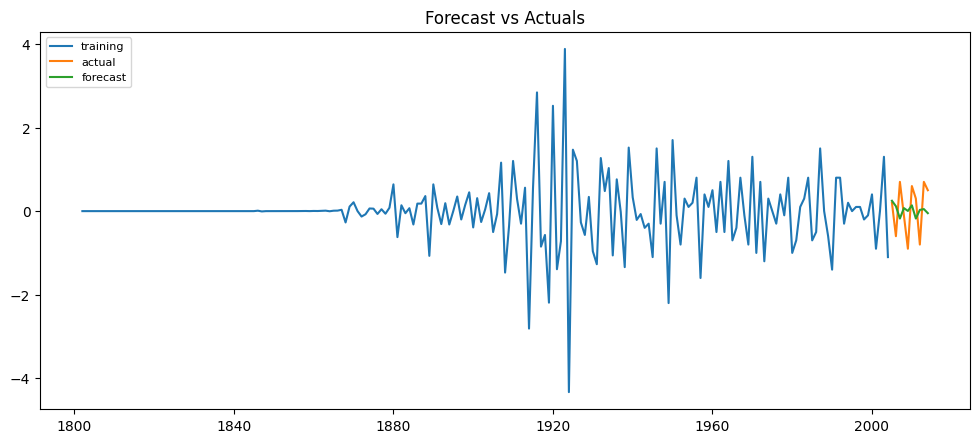

In [92]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_ar, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Moving Average (MA) model

In [97]:
# only use q or MA parameter
#MA(3)
model_ma = stats.ARIMA(train['CO2'],order = (0,1,3))
model_ma = model_ma.fit()
model_ma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    CO2   No. Observations:                  203
Model:                 ARIMA(0, 1, 3)   Log Likelihood                -175.110
Date:                Mon, 20 Dec 2021   AIC                            358.220
Time:                        19:57:03   BIC                            371.453
Sample:                    01-01-1802   HQIC                           363.574
                         - 01-01-2004                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -2.0456      0.975     -2.097      0.036      -3.958      -0.134
ma.L2          1.0932      1.014      1.078      0.281      -0.894       3.081
ma.L3         -0.0468      0.054     -0.867      0.386      -0.153       0.059
sigma2         0.3055      0.299      1.022      0.307      -0.280       0.891
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               136.88
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):             402.72   Skew:                            -0.68
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [98]:
pred_ma = model_ma.predict(start=start,end=end)
print(pred_ma)

2005-01-01    0.332865
2006-01-01   -0.015746
2007-01-01   -0.002322
2008-01-01   -0.002322
2009-01-01   -0.002322
2010-01-01   -0.002322
2011-01-01   -0.002322
2012-01-01   -0.002322
2013-01-01   -0.002322
2014-01-01   -0.002322
Freq: AS-JAN, Name: predicted_mean, dtype: float64


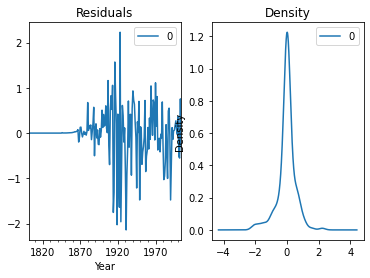

In [99]:
# Plot residual errors
residuals = pd.DataFrame(model_ma.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [100]:
stationary_ma_acc = forecast_accuracy(pred_ma.values, test.values)
stationary_ma_acc

{'mae': 0.53734372487731,
 'mape': 1.0130014817685966,
 'me': -0.030145625148009687,
 'mpe': -0.997523982403148,
 'rmse': 0.60127073054565}

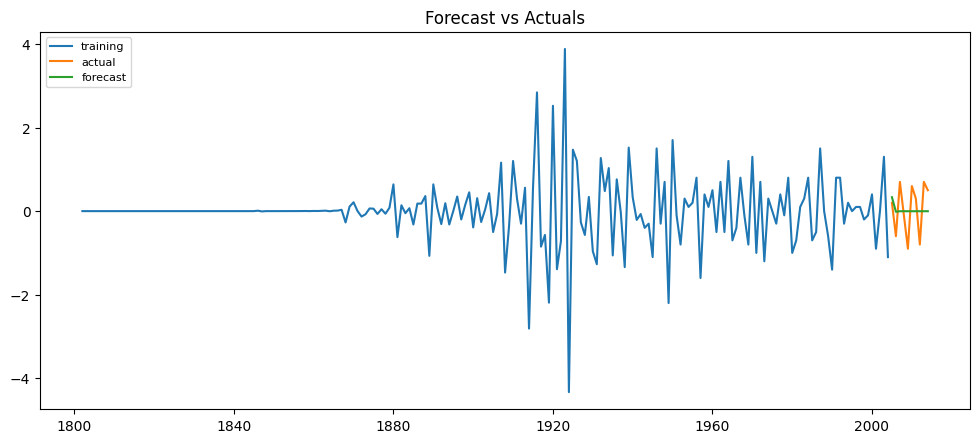

In [101]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_ma, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Auto ARIMA model

In [102]:
model = pm.auto_arima(train['CO2'], start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=486.563, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=438.526, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=398.404, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=388.893, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=344.374, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=346.067, Time=0.24 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.52 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0]          
Total fit time: 1.955 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. O

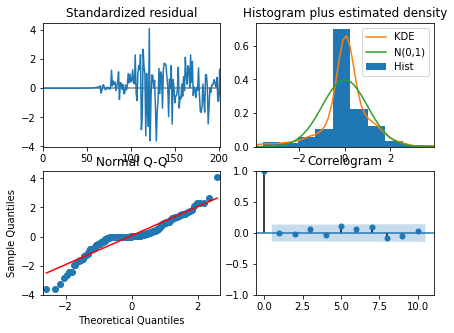

In [103]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

In [112]:
pred = model.predict(start=start,end=end)
print(pred)

[ 2.20055825e-01  1.18263523e-01 -3.25375264e-02 -1.22290136e-02
  4.52336794e-03  1.20113760e-03 -6.01541238e-04 -1.09372563e-04
  7.72408131e-05  8.73005360e-06]


In [113]:
stationary_aa_acc = forecast_accuracy(pred, test.values)
stationary_aa_acc

{'mae': 0.5344280690862558,
 'mape': 0.9995286640175626,
 'me': -0.030134762943557075,
 'mpe': -0.9975230815298423,
 'rmse': 0.5973108960435066}

In [116]:
data = {"MODEL":pd.Series(["ARIMA","Auto Regressor","Moving Average","Auto ARIMA"]),"RMSE_Values":pd.Series([stationary_arima_acc["rmse"],stationary_ar_acc["rmse"],
stationary_ma_acc["rmse"],stationary_aa_acc["rmse"]]),"MAPE_values":pd.Series([stationary_arima_acc["mape"],stationary_ar_acc["mape"],stationary_ma_acc["mape"],stationary_aa_acc["mape"]]),
"ME_values":pd.Series([stationary_arima_acc["me"],stationary_ar_acc["me"],stationary_ma_acc["me"],stationary_aa_acc["me"]]),
"MAE_values":pd.Series([stationary_arima_acc["mae"],stationary_ar_acc["mae"],stationary_ma_acc["mae"],stationary_aa_acc["mae"]]),
        "MPE_values":pd.Series([stationary_arima_acc["mpe"],stationary_ar_acc["mpe"],stationary_ma_acc["mpe"],stationary_aa_acc["mpe"]])}

table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values'])

,MODEL,RMSE_Values,MAPE_values,ME_values,MAE_values,MPE_values
3,Auto ARIMA,0.597311,0.999529,-0.030135,0.534428,-0.997523
2,Moving Average,0.601271,1.013001,-0.030146,0.537344,-0.997524
0,ARIMA,0.602991,1.021137,-0.037295,0.538540,-0.998117
1,Auto Regressor,0.606429,1.033614,-0.034564,0.538961,-0.997890


# **B) MODEL BUILDING ON NON-STATIONARY DATA / ORIGINAL DATA**

In [117]:
df.head()

,CO2
Year,
1800-01-01,0.00568
1801-01-01,0.00561
1802-01-01,0.00555
1803-01-01,0.00548
1804-01-01,0.00542


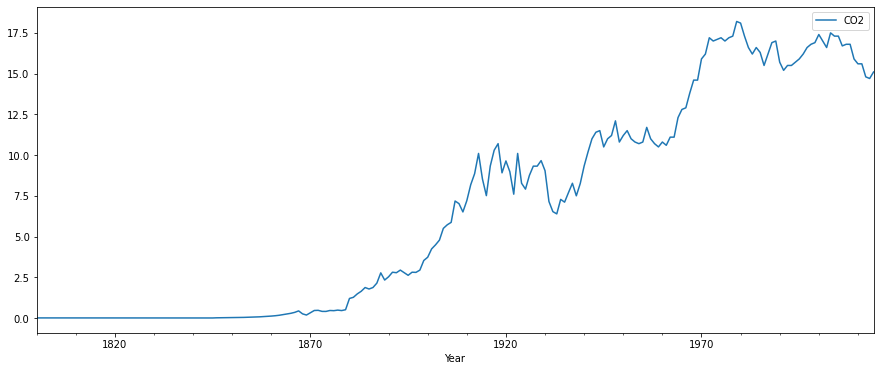

In [118]:
df.plot(figsize=(15, 6))
plt.show()

## Data Partitioning

In [119]:
train = df[:195]
test = df[195:]
print(train.shape,test.shape)

(195, 1) (20, 1)


In [120]:
train.head()

,CO2
Year,
1800-01-01,0.00568
1801-01-01,0.00561
1802-01-01,0.00555
1803-01-01,0.00548
1804-01-01,0.00542


In [121]:
test.head()

,CO2
Year,
1995-01-01,15.9
1996-01-01,16.2
1997-01-01,16.6
1998-01-01,16.8
1999-01-01,16.9


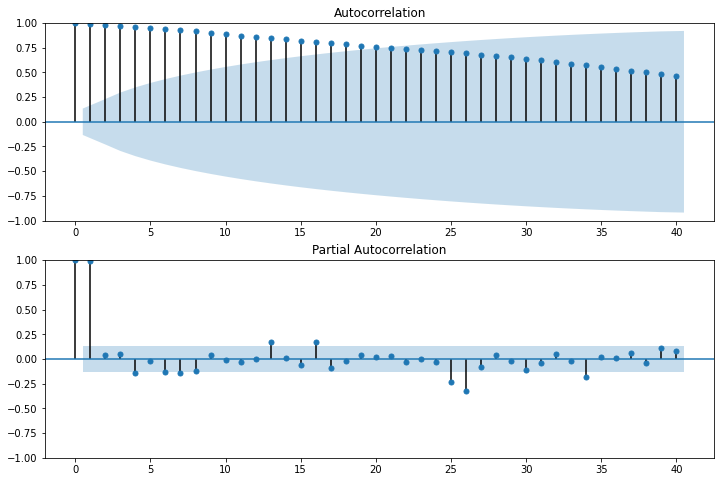

In [122]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df, lags=40, ax=ax2)

### Hyper-parameter Tuning : Finding out optimal (p,d,q)


In [126]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(train, test, arima_order):
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = stats.ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [127]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(train, test, p_values, d_values, q_values):
    #dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(train, test, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [128]:
# evaluate parameters
p_values = [0,1,2,3,4,5]
d_values = range(0, 5)
q_values = range(0, 5)
warnings.filterwarnings("ignore")
evaluate_models(train.values, test.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=10.175
ARIMA(0, 0, 1) RMSE=5.218
ARIMA(0, 0, 2) RMSE=3.120
ARIMA(0, 0, 3) RMSE=1.965
ARIMA(0, 0, 4) RMSE=1.886
ARIMA(0, 1, 0) RMSE=0.438
ARIMA(0, 1, 1) RMSE=0.439
ARIMA(0, 1, 2) RMSE=0.439
ARIMA(0, 1, 3) RMSE=0.424
ARIMA(0, 1, 4) RMSE=0.424
ARIMA(0, 2, 0) RMSE=0.612
ARIMA(0, 2, 1) RMSE=0.451
ARIMA(0, 2, 2) RMSE=0.454
ARIMA(0, 2, 3) RMSE=0.458
ARIMA(0, 2, 4) RMSE=0.443
ARIMA(0, 3, 0) RMSE=1.037
ARIMA(0, 3, 1) RMSE=0.613
ARIMA(0, 3, 2) RMSE=0.450
ARIMA(0, 3, 3) RMSE=0.455
ARIMA(0, 3, 4) RMSE=0.458
ARIMA(0, 4, 0) RMSE=1.853
ARIMA(0, 4, 1) RMSE=1.039
ARIMA(0, 4, 2) RMSE=0.679
ARIMA(0, 4, 3) RMSE=0.446
ARIMA(0, 4, 4) RMSE=0.441
ARIMA(1, 0, 0) RMSE=0.437
ARIMA(1, 0, 1) RMSE=0.438
ARIMA(1, 0, 2) RMSE=0.438
ARIMA(1, 0, 3) RMSE=0.423
ARIMA(1, 0, 4) RMSE=0.423
ARIMA(1, 1, 0) RMSE=0.439
ARIMA(1, 1, 1) RMSE=0.433
ARIMA(1, 1, 2) RMSE=0.431
ARIMA(1, 1, 3) RMSE=0.437
ARIMA(1, 1, 4) RMSE=0.440
ARIMA(1, 2, 0) RMSE=0.544
ARIMA(1, 2, 1) RMSE=0.453
ARIMA(1, 2, 2) RMSE=0.446
ARIMA(1, 2,

## ARIMA

In [ ]:
model_arima = stats.ARIMA(train['CO2'],order = (5,1,3))
model_arima = model_arima.fit()
model_arima.summary()


In [ ]:
start = len(train)
end = len(train)+len(test)-1
pred_arima = model_arima.predict(start=start,end=end)
print(pred_arima)

In [ ]:
model_arima.plot_diagnostics(figsize=(7,5))
plt.show()

In [ ]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_arima, label='forecast')
#plt.fill_between(lower_series.index, lower_series, upper_series, 
                 #color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [136]:
ns_arima_acc = forecast_accuracy(pred_arima,test.CO2)
ns_arima_acc

{'mae': 0.9029937341792487,
 'mape': 0.05428945045482138,
 'me': -0.6289560568922775,
 'mpe': -0.03588383151391379,
 'rmse': 1.0268684879959935}

## Auto ARIMA

In [161]:
model_auto = pm.auto_arima(train['CO2'], start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=4, max_q=4, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model_auto.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=327.249, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=328.890, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=328.788, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=329.304, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=330.241, Time=0.24 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.462 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  195
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -161.625
Date:                Mon, 20 Dec 2021   AIC                            327.249
Time:                        20:59:24   BIC                            333.785
Sample:                             0   HQIC                           329.896
                                - 195                                         
Co

In [162]:
pred_auto_ar = model_auto.predict(start=start,end=end,dynamic = False)
print(pred_auto_ar)

[15.78089834 15.86179668 15.94269502 16.02359336 16.1044917  16.18539004
 16.26628838 16.34718672 16.42808507 16.50898341]


In [163]:
ns_auto_ar_acc = forecast_accuracy(pred_auto_ar.values, test.values)
ns_auto_ar_acc

AttributeError: ignored

In [ ]:
model_auto.plot_diagnostics(figsize=(7,5))
plt.show()

## Auto Regressor 

In [ ]:
model_ar = AutoReg(train,lags = 1).fit()
print(model_ar.summary())

In [ ]:
pred_ar = model_ar.predict(start=start,end=end,dynamic = False)
print(pred_ar)

In [153]:
ns_ar_acc = forecast_accuracy(pred_ar.values, test.values)
ns_ar_acc

{'mae': 0.7960986374051173,
 'mape': 0.04987211514114989,
 'me': 0.22310031674082897,
 'mpe': 0.016375885511672548,
 'rmse': 0.997842712139575}

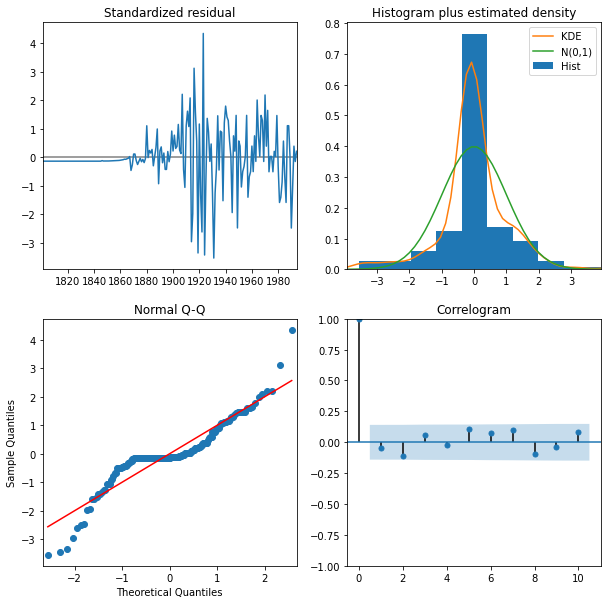

In [165]:
model_ar.plot_diagnostics(figsize=(10,10))
plt.show()

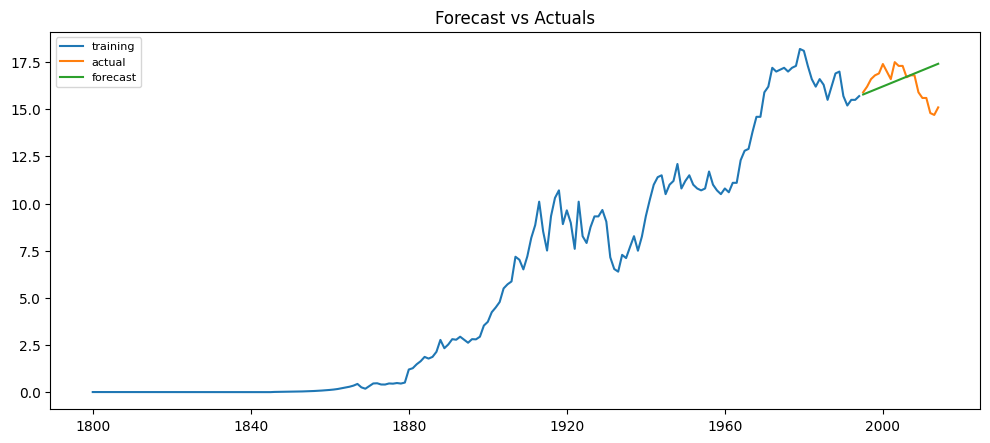

In [166]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_ar, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

##4. Single Exponential Smoothing

In [167]:
fit1 = SimpleExpSmoothing(train).fit(smoothing_level = 0.2,optimized = False)
fit2 =SimpleExpSmoothing(train).fit(smoothing_level = 0.8,optimized = False)

Text(0.5, 1.0, 'Fitted values Vs Original Values')

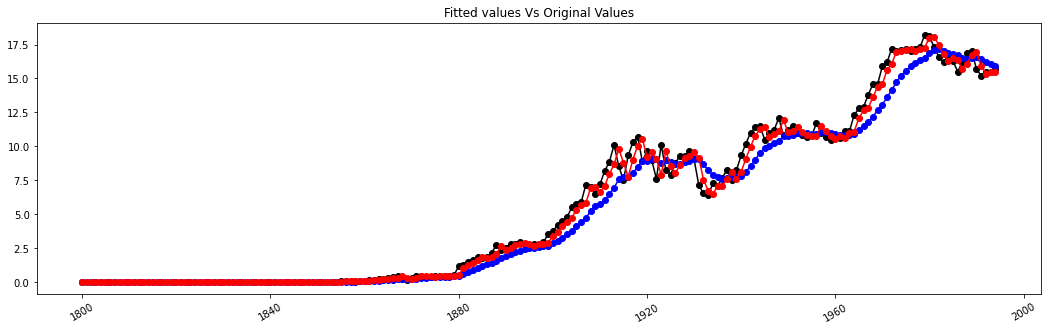

In [168]:
plt.figure(figsize=(18,5))
plt.plot(train,marker = 'o',color = 'black')
plt.xticks(rotation=30)
plt.plot(fit1.fittedvalues,marker = 'o',color = 'blue')
plt.plot(fit2.fittedvalues,marker = 'o',color = 'red')
plt.title('Fitted values Vs Original Values')

In [169]:
pred_ses = fit1.predict(start = len(train),end = len(train)+len(test)-1)

In [170]:
ns_ses_acc = forecast_accuracy(pred_ses,test.CO2)
ns_ses_acc

{'mae': 0.8501648996190075,
 'mape': 0.05140341313825274,
 'me': -0.48532979923801467,
 'mpe': -0.027004457582465242,
 'rmse': 0.9682045310926879}

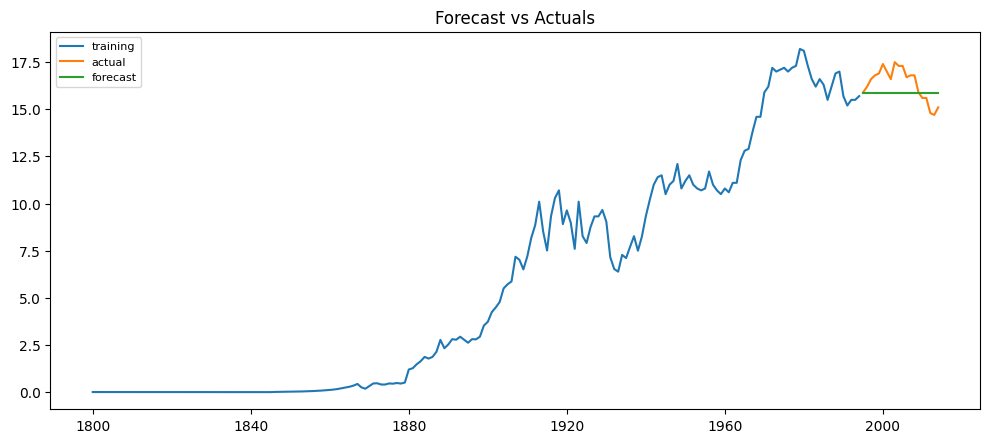

In [171]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_ses, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Double Exponential Smoothing or Holt's method

In [172]:
#fit1 = Holt(train1).fit()
fit3 = Holt(train,exponential=True,damped_trend=False).fit()

Text(0.5, 1.0, 'Fitted values Vs Original Values')

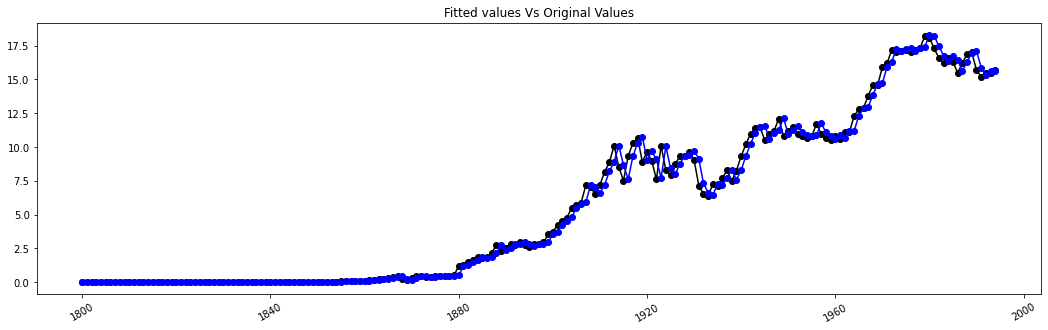

In [173]:
plt.figure(figsize=(18,5))
plt.plot(train,marker = 'o',color = 'black')
plt.xticks(rotation=30)
plt.plot(fit3.fittedvalues,marker = 'o',color = 'blue')
#plt.plot(fit2.fittedvalues,marker = 'o',color = 'red')
plt.title('Fitted values Vs Original Values')

In [174]:
pred_holt = fit3.predict(start = len(train),end = len(train)+len(test)-1)

In [175]:
ns_des_acc = forecast_accuracy(pred_holt,test.CO2)
ns_des_acc

{'mae': 1.087091684540156,
 'mape': 0.06935413707304539,
 'me': 0.5653159571769144,
 'mpe': 0.03873735144148585,
 'rmse': 1.4907763747969702}

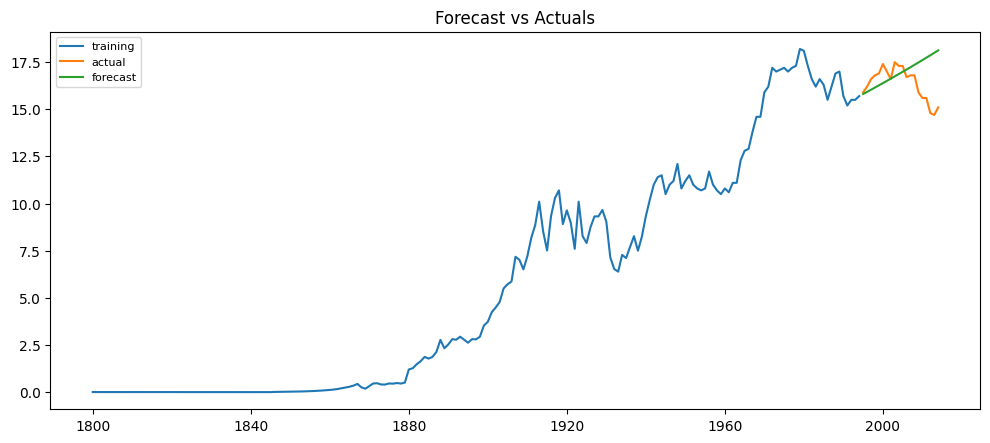

In [176]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_holt, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Triple Exponential Smoothing or Holt - Winter's Method

# **i) seasonality = additive** , **Trend = additive**

In [177]:
# Holts winter exponential smoothing with additive seasonality and additive trend
hwe_model_add_add = ExponentialSmoothing(train["CO2"],seasonal="add",trend="add",seasonal_periods=2,damped=True).fit()
pred_hwe_add_add = hwe_model_add_add.predict(start = start,end = end)

In [178]:
ns_tes_add_add_acc = forecast_accuracy(pred_hwe_add_add,test.CO2)
ns_tes_add_add_acc

{'mae': 0.9298767517152047,
 'mape': 0.0570215712100244,
 'me': -0.3114759145488863,
 'mpe': -0.01595460627633874,
 'rmse': 1.022883351714417}

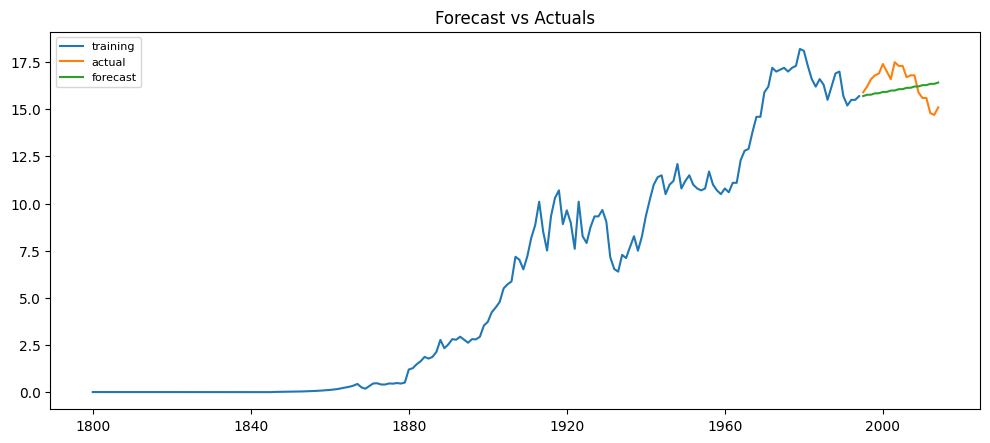

In [179]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_hwe_add_add, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# **ii) seasonality = multiplicative** , **Trend = additive**

In [180]:
# Holts winter exponential smoothing with multiplicative seasonality and additive trend
hwe_model_mul_add = ExponentialSmoothing(train["CO2"],seasonal="mul",trend="add",seasonal_periods=2).fit()
pred_hwe_mul_add = hwe_model_mul_add.predict(start = start,end = end)

In [181]:
ns_tes_mul_add_acc = forecast_accuracy(pred_hwe_mul_add,test.CO2)
ns_tes_mul_add_acc

{'mae': 0.9435894403340743,
 'mape': 0.05934310862576272,
 'me': 0.12855308589642966,
 'mpe': 0.011502288764283875,
 'rmse': 1.1829065816077504}

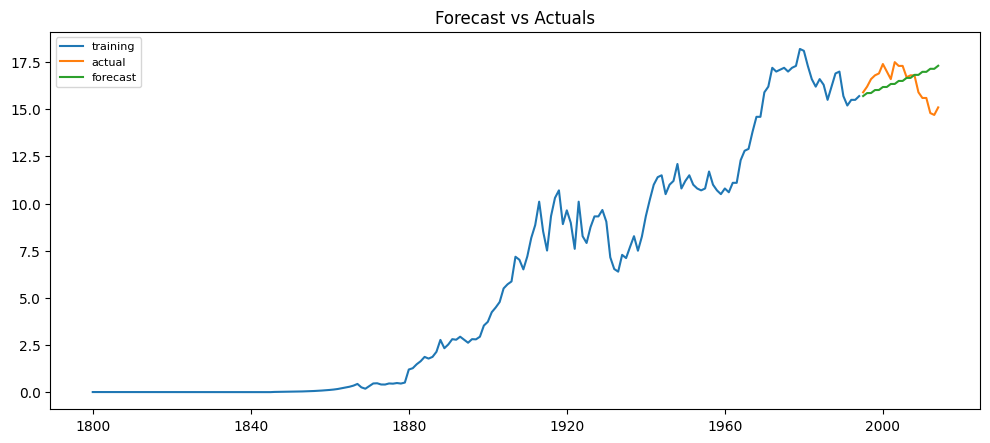

In [182]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_hwe_mul_add, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# **iii) seasonality = multiplicative , Trend = multiplicative**

In [183]:
# Holts winter exponential smoothing with multiplicative seasonality and additive trend
hwe_model_mul_mul = ExponentialSmoothing(train["CO2"],seasonal="mul",trend="mul",seasonal_periods=2).fit()
pred_hwe_mul_mul = hwe_model_mul_add.predict(start = start,end = end)

In [184]:
ns_tes_mul_mul_acc = forecast_accuracy(pred_hwe_mul_mul,test.CO2)
ns_tes_mul_mul_acc

{'mae': 0.9435894403340743,
 'mape': 0.05934310862576272,
 'me': 0.12855308589642966,
 'mpe': 0.011502288764283875,
 'rmse': 1.1829065816077504}

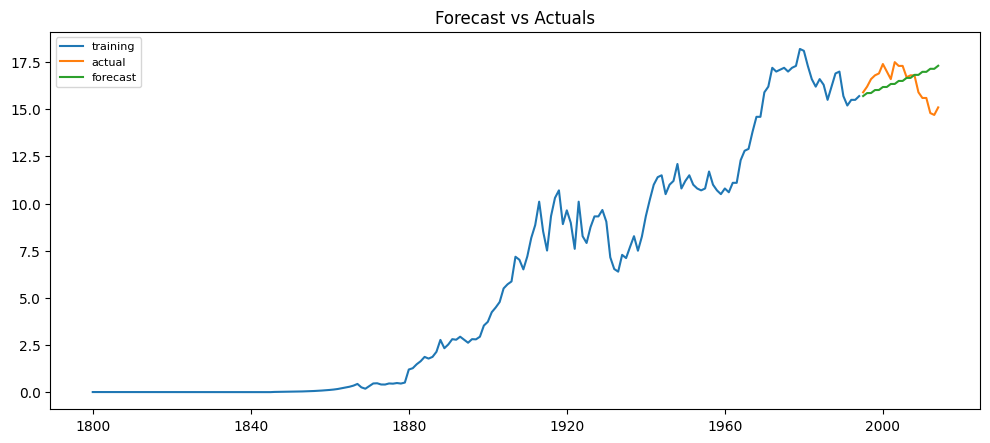

In [185]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_hwe_mul_mul, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## LSTM using RNN

In [186]:
scaler = MinMaxScaler()

In [187]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [188]:
scaled_train[:10]

array([[0.00021595],
       [0.00021211],
       [0.00020881],
       [0.00020496],
       [0.00020167],
       [0.00019837],
       [0.00019452],
       [0.00019123],
       [0.00018793],
       [0.00018463]])

In [189]:
#define generator
n_input = 5
n_features = 1
generator = TimeseriesGenerator(scaled_train,scaled_train,length=n_input,batch_size=1)

In [190]:
X,y = generator[0]
print(f'given the array: \n{X.flatten()}')
print(f'predict this y: \n {y}')

given the array: 
[0.00021595 0.00021211 0.00020881 0.00020496 0.00020167]
predict this y: 
 [[0.00019837]]


In [191]:
X.shape

(1, 5, 1)

In [192]:
#define model
model = Sequential()
model.add(LSTM(60, activation = 'relu',return_sequences = True, input_shape=(n_input,n_features)))
model.add(Dropout(0.2))

model.add(LSTM(60, activation = 'relu', return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(60, activation = 'relu', return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(60, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(units = 1))
model.compile(optimizer='adam',loss='mean_squared_error')

In [193]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 60)             14880     
                                                                 
 dropout (Dropout)           (None, 5, 60)             0         
                                                                 
 lstm_1 (LSTM)               (None, 5, 60)             29040     
                                                                 
 dropout_1 (Dropout)         (None, 5, 60)             0         
                                                                 
 lstm_2 (LSTM)               (None, 5, 60)             29040     
                                                                 
 dropout_2 (Dropout)         (None, 5, 60)             0         
                                                                 
 lstm_3 (LSTM)               (None, 60)                2

In [194]:
#fit model
model.fit(generator,epochs=50,batch_size=32,verbose=1)

Epoch 1/50
190/190 [==============================] - 9s 14ms/step - loss: 0.0771
Epoch 2/50
190/190 [==============================] - 3s 15ms/step - loss: 0.0130
Epoch 3/50
190/190 [==============================] - 3s 14ms/step - loss: 0.0106
Epoch 4/50
190/190 [==============================] - 3s 15ms/step - loss: 0.0098
Epoch 5/50
190/190 [==============================] - 3s 14ms/step - loss: 0.0095
Epoch 6/50
190/190 [==============================] - 2s 13ms/step - loss: 0.0089
Epoch 7/50
190/190 [==============================] - 3s 14ms/step - loss: 0.0092
Epoch 8/50
190/190 [==============================] - 3s 14ms/step - loss: 0.0079
Epoch 9/50
190/190 [==============================] - 2s 13ms/step - loss: 0.0087
Epoch 10/50
190/190 [==============================] - 3s 13ms/step - loss: 0.0098
Epoch 11/50
190/190 [==============================] - 3s 14ms/step - loss: 0.0098
Epoch 12/50
190/190 [==============================] - 3s 14ms/step - loss: 0.0089
Epoch 13/50
1

Text(0.5, 1.0, 'Loss per Epochs')

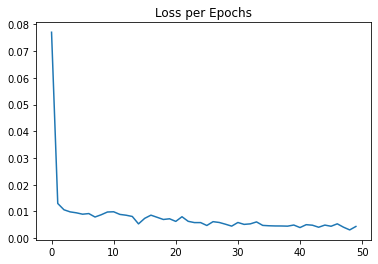

In [195]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)
plt.title('Loss per Epochs')

In [196]:
last_train_batch = scaled_train[-5:]

In [197]:
last_train_batch = last_train_batch.reshape(1,n_input,n_features)

In [198]:
model.predict(last_train_batch)

array([[0.87951213]], dtype=float32)

In [199]:
scaled_test[0]

array([0.87361422])

In [200]:
test_predictions =[]

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape(1,n_input,n_features)

for i in range(len(test)):
    
    #get the prediction value for first batch
    current_pred = model.predict(current_batch)[0]
    
    #append the prediction into the array
    test_predictions.append(current_pred)
    
    #use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis =1)

In [201]:
test_predictions

[array([0.87951213], dtype=float32),
 array([0.8783691], dtype=float32),
 array([0.8806647], dtype=float32),
 array([0.8818728], dtype=float32),
 array([0.88353986], dtype=float32),
 array([0.88460565], dtype=float32),
 array([0.88465], dtype=float32),
 array([0.8848581], dtype=float32),
 array([0.88500243], dtype=float32),
 array([0.88513064], dtype=float32),
 array([0.88519084], dtype=float32),
 array([0.88520205], dtype=float32),
 array([0.8852197], dtype=float32),
 array([0.8852324], dtype=float32),
 array([0.8852412], dtype=float32),
 array([0.88524485], dtype=float32),
 array([0.88524634], dtype=float32),
 array([0.8852478], dtype=float32),
 array([0.8852487], dtype=float32),
 array([0.88524926], dtype=float32)]

In [202]:
test.head()

,CO2
Year,
1995-01-01,15.9
1996-01-01,16.2
1997-01-01,16.6
1998-01-01,16.8
1999-01-01,16.9


In [203]:
true_predictions = scaler.inverse_transform(test_predictions)

In [204]:
test['Predictions'] = true_predictions

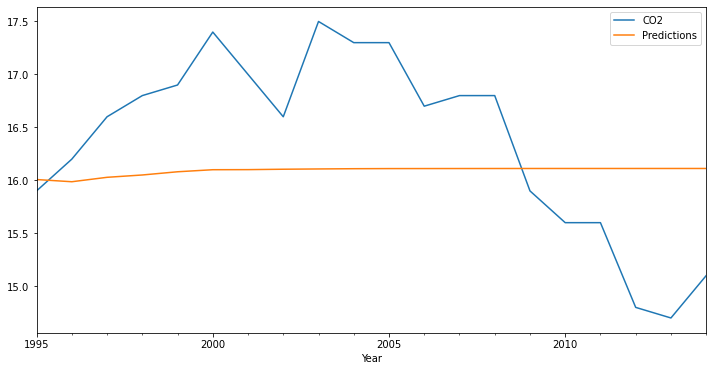

In [205]:
test.plot(figsize=(12,6))

In [206]:
ns_lstm_acc = forecast_accuracy(test['Predictions'],test.CO2)
ns_lstm_acc

{'mae': 0.7932600667342549,
 'mape': 0.04849511220711981,
 'me': -0.28551609164625535,
 'mpe': -0.014762681507029213,
 'rmse': 0.8869542592934359}

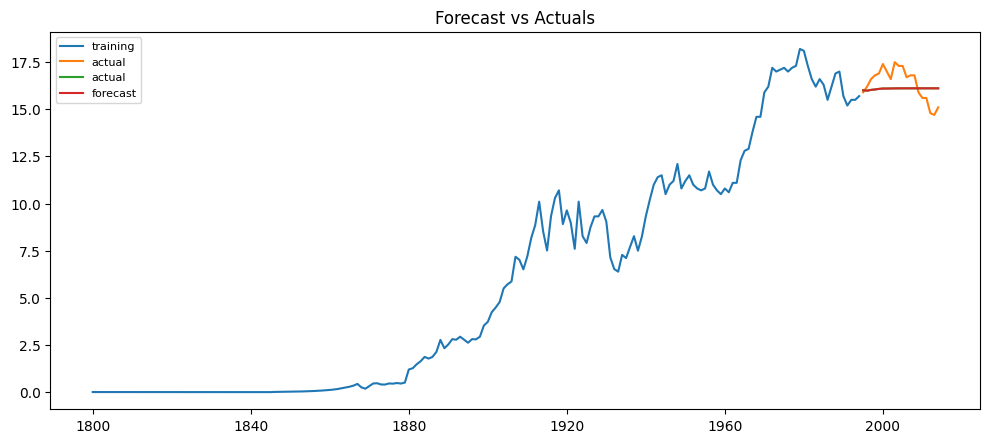

In [207]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(test['Predictions'], label='forecast')
#plt.fill_between(lower_series.index, lower_series, upper_series, 
                 #color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Forecasting Accuracy

In [209]:
data = {"MODEL":pd.Series(["ARIMA(5,1,3)","Auto Regressor","single exponential smoothing","Double exponential smoothing","Triple exponential smoothing(additive seasonality & additive trend)","Triple exponential smoothing(multiplicative seasonality & additive trend)","Triple exponential smoothing(multiplicative seasonality & multiplicative trend)","LSTM(RNN)"]),
"RMSE_values":pd.Series([ns_arima_acc["rmse"],ns_ar_acc["rmse"],ns_ses_acc["rmse"],ns_des_acc["rmse"],ns_tes_add_add_acc["rmse"],ns_tes_mul_add_acc["rmse"],ns_tes_mul_mul_acc["rmse"],ns_lstm_acc["rmse"]]),
"MAPE_values":pd.Series([ns_arima_acc["mape"],ns_ar_acc["mape"],ns_ses_acc["mape"],ns_des_acc["mape"],ns_tes_add_add_acc["mape"],ns_tes_mul_add_acc["mape"],ns_tes_mul_mul_acc["mape"],ns_lstm_acc["mape"]]),
"ME_values":pd.Series([ns_arima_acc["me"],ns_ar_acc["me"],ns_ses_acc["me"],ns_des_acc["me"],ns_tes_add_add_acc["me"],ns_tes_mul_add_acc["me"],ns_tes_mul_mul_acc["me"],ns_lstm_acc["me"]]),
"MAE_values":pd.Series([ns_arima_acc["mae"],ns_ar_acc["mae"],ns_ses_acc["mae"],ns_des_acc["mae"],ns_tes_add_add_acc["mae"],ns_tes_mul_add_acc["mae"],ns_tes_mul_mul_acc["mae"],ns_lstm_acc["mae"]]),
"MPE_values":pd.Series([ns_arima_acc["mpe"],ns_ar_acc["mpe"],ns_ses_acc["mpe"],ns_des_acc["mpe"],ns_tes_add_add_acc["mpe"],ns_tes_mul_add_acc["mpe"],ns_tes_mul_mul_acc["mpe"],ns_lstm_acc["mpe"]])}

table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['MAPE_values'])

,MODEL,RMSE_values,MAPE_values,ME_values,MAE_values,MPE_values
7,LSTM(RNN),0.886954,0.048495,-0.285516,0.793260,-0.014763
1,Auto Regressor,0.997843,0.049872,0.223100,0.796099,0.016376
2,single exponential smoothing,0.968205,0.051403,-0.485330,0.850165,-0.027004
0,"ARIMA(5,1,3)",1.026868,0.054289,-0.628956,0.902994,-0.035884
4,Triple exponential smoothing(additive seasonal...,1.022883,0.057022,-0.311476,0.929877,-0.015955
5,Triple exponential smoothing(multiplicative se...,1.182907,0.059343,0.128553,0.943589,0.011502
6,Triple exponential smoothing(multiplicative se...,1.182907,0.059343,0.128553,0.943589,0.011502
3,Double exponential smoothing,1.490776,0.069354,0.565316,1.087092,0.038737


# Final Model

We have selected **ARIMA(5,1,3)** as our final model beacuse of following reasons:
- least MAPE & MAE value
- Forecasted values vs Actual values graphs capturing more information when compared to other models

In [210]:
final_arima = stats.ARIMA(df['CO2'],order = (5,1,3))
final_arima = final_arima.fit()
final_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    CO2   No. Observations:                  215
Model:                 ARIMA(5, 1, 3)   Log Likelihood                -167.227
Date:                Mon, 20 Dec 2021   AIC                            352.454
Time:                        21:29:22   BIC                            382.748
Sample:                    01-01-1800   HQIC                           364.696
                         - 01-01-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0999      0.295      3.728      0.000       0.522       1.678
ar.L2          0.3736      0.537      0.696      0.486      -0.678       1.426
ar.L3         -0.4150      0.303     -1.370      0.171      -1.009       0.179
ar.L4         -0.0990      0.113     -0.878      0.380      -0.320       0.122
ar.L5         -0.0722      0.081     -0.895      0.371      -0.230       0.086
ma.L1         -1.1766      0.302     -3.899      0.000      -1.768      -0.585
ma.L2         -0.4371      0.555     -0.788      0.431      -1.525       0.651
ma.L3          0.7288      0.279      2.609      0.009       0.181       1.276
sigma2         0.2760      0.022     12.663      0.000       0.233       0.319
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                84.98
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):             231.96   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [231]:
df1=final_arima.fittedvalues
df1.tail()

Year
2010-01-01    15.733396
2011-01-01    15.423352
2012-01-01    15.292987
2013-01-01    14.538979
2014-01-01    14.540674
dtype: float64

In [ ]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df, label='original')
#plt.plot(test, label='actual')
plt.plot(df1, label='forecast')
plt.title('Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### creating dataframe for future forecasting

In [246]:
future_dates=[df1.index[-1]+ DateOffset(years=x)for x in range(0,6)]
future_dates

[Timestamp('2014-01-01 00:00:00'),
 Timestamp('2015-01-01 00:00:00'),
 Timestamp('2016-01-01 00:00:00'),
 Timestamp('2017-01-01 00:00:00'),
 Timestamp('2018-01-01 00:00:00'),
 Timestamp('2019-01-01 00:00:00')]

In [258]:
future_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)

In [259]:
future_df.tail()

,CO2
2015-01-01,NaN
2016-01-01,NaN
2017-01-01,NaN
2018-01-01,NaN
2019-01-01,NaN


In [260]:
len(future_df)

5

### Forecasting for  next 5 years using Final ARIMA model

In [261]:
future_df['CO2'] = final_arima.predict(start = 215, end = 220, dynamic= True)  
#future_df[['CO2', 'forecast']].plot(figsize=(12, 8))
#plt.title('Forecast for next 5 years')

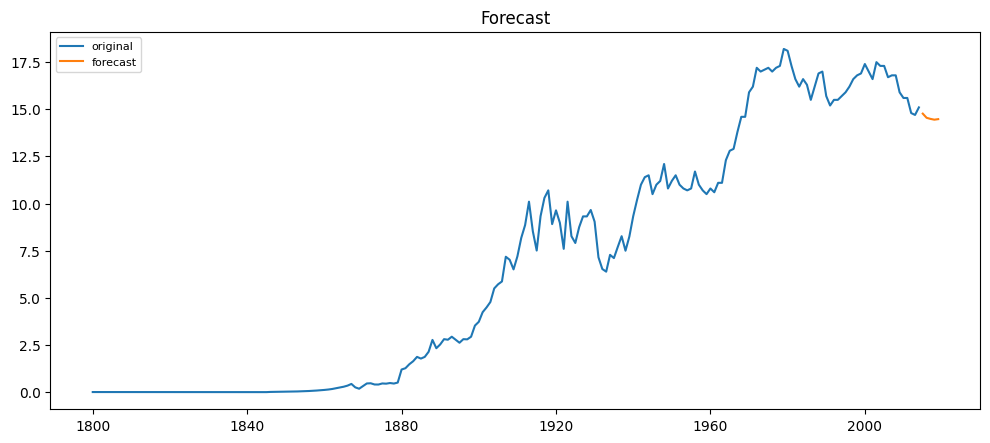

In [262]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df, label='original')
#plt.plot(test, label='actual')
plt.plot(future_df['CO2'], label='forecast')
plt.title('Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [263]:
df.tail()

,CO2
Year,
2010-01-01,15.6
2011-01-01,15.6
2012-01-01,14.8
2013-01-01,14.7
2014-01-01,15.1


In [264]:
future_df.tail()

,CO2
2015-01-01,14.769052
2016-01-01,14.547840
2017-01-01,14.489900
2018-01-01,14.448499
2019-01-01,14.476989


In [265]:
# Exporting to csv file
future_df.to_csv(r'forecast_data_5years.csv',index=True)

## Forecast for 10 years

In [268]:
future_dates_10=[df1.index[-1]+ DateOffset(years=x)for x in range(0,11)]
future_df_10=pd.DataFrame(index=future_dates_10[1:],columns=df.columns)
future_df_10.tail()
len(future_df_10)

10

In [269]:
future_df_10['CO2'] = final_arima.predict(start = 215, end = 225, dynamic= True) 

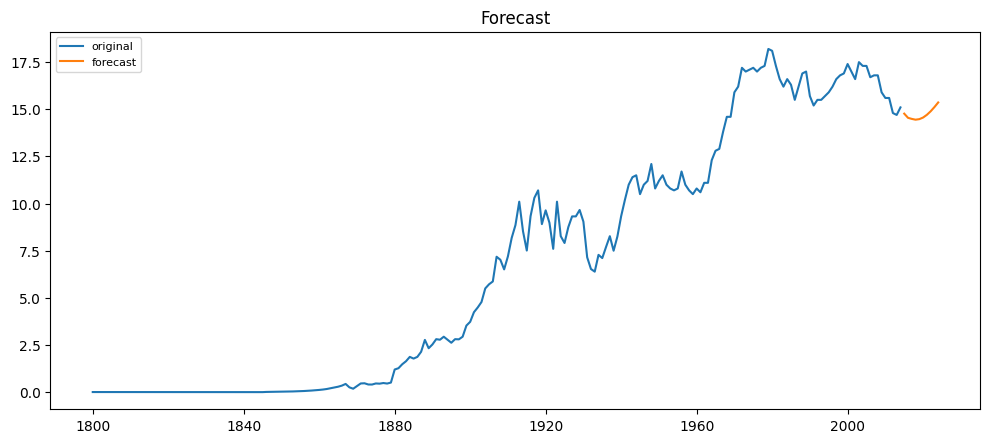

In [270]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df, label='original')
#plt.plot(test, label='actual')
plt.plot(future_df_10['CO2'], label='forecast')
plt.title('Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [271]:
future_df_10

,CO2
2015-01-01,14.769052
2016-01-01,14.547840
2017-01-01,14.489900
2018-01-01,14.448499
2019-01-01,14.476989
2020-01-01,14.562689
2021-01-01,14.706481
2022-01-01,14.893113
2023-01-01,15.116717
2024-01-01,15.362176


In [272]:
# Exporting to csv file
future_df_10.to_csv(r'forecast_data_10years.csv',index=True)

In [273]:
# Saving the pickle file
import pickle
pickle.dump(final_arima, open('Forecast_arima.pkl','wb'))